In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import *
import time
import ott

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from entot.models.utils import MLP, MLP_FM

from ott.solvers.nn.models import ModelBase, NeuralTrainState
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
import pandas as pd
from entot.models.gen_model import OTFlowMatching, MLP_FM, MLP_FM2, MLP_FM3, MLP_no_noise, OriginalFlowMatching, MLP_FM_VAE, Bridge_MLP, Bridge_MLP_with_t

2023-07-21 11:44:45.739563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from entot.models.utils import MixtureNormalSampler
source = MixtureNormalSampler([0], 1,  0.5, batch_size=2048)(jax.random.PRNGKey(0))
target = MixtureNormalSampler([-1.0,1.0], 1,  0.1, batch_size=2048)(jax.random.PRNGKey(0))

<Axes: ylabel='Density'>

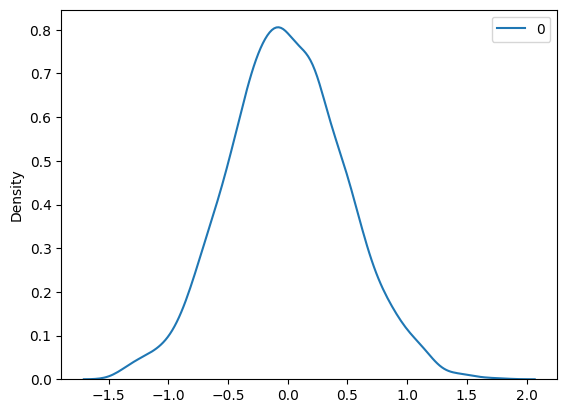

In [5]:
sns.kdeplot(source)

<Axes: ylabel='Density'>

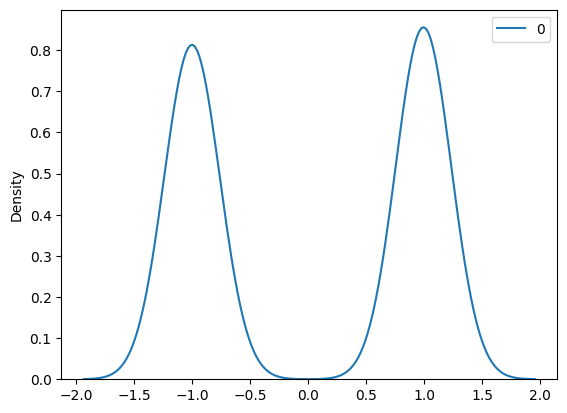

In [6]:
sns.kdeplot(target)

In [10]:
#neural_net = MLP_FM3(1, 32, 32, 32, n_frequencies=10)
#neural_net = MLP_FM(1, [64, 64, 64, 64], n_frequencies=1)
neural_net = MLP_no_noise(1, 64, 64, 64)
bridge_net = Bridge_MLP(1, 32, 32)

In [11]:
#cosine_decay_scheduler = optax.cosine_decay_schedule(1e-3, decay_steps=1_000, alpha=0.95)
#optimizer = optax.adamw(learning_rate=cosine_decay_scheduler)
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-2, input_dim=1, output_dim=1, iterations=1_000, noise_std=1e-1, k_noise_per_x=20)

In [12]:
otfm.iterations=4_000
otfm(source, target, 256, 256)

100%|██████████| 4000/4000 [03:16<00:00, 20.34it/s]


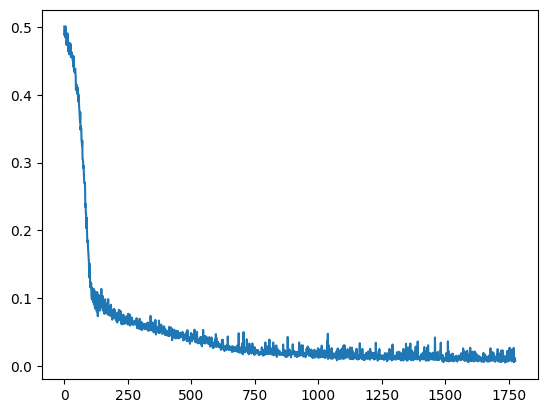

In [13]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

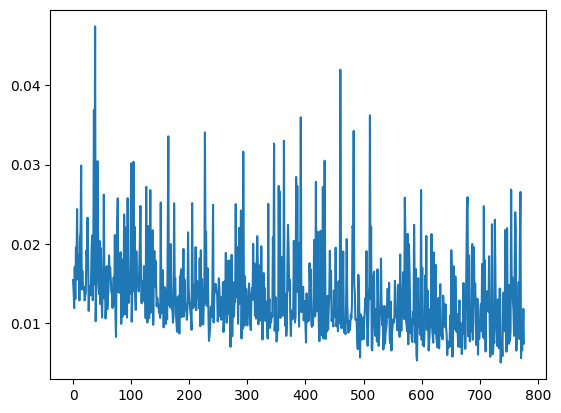

In [14]:
plt.plot(np.arange(len(otfm.metrics["loss"][1000:])), otfm.metrics["loss"][1000:])

In [13]:
res, _ = otfm.transport(source, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})

In [14]:
source_sorted = jnp.sort(source, axis=0)

In [20]:
r =otfm.state_bridge_net.apply_fn({"params": otfm.state_bridge_net.params}, t=0, condition=source_sorted)
r2 =otfm.state_bridge_net.apply_fn({"params": otfm.state_bridge_net.params}, t=0.2, condition=source_sorted)
r3 =otfm.state_bridge_net.apply_fn({"params": otfm.state_bridge_net.params}, t=0.4, condition=source_sorted)

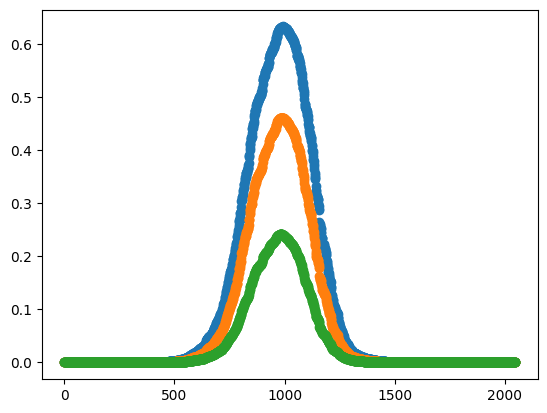

In [23]:
plt.scatter(np.arange(len(r[1])), r[1])
plt.scatter(np.arange(len(r[1])), r2[1])
plt.scatter(np.arange(len(r[1])), r3[1])
# Try MLP_VAE... with constant variance.

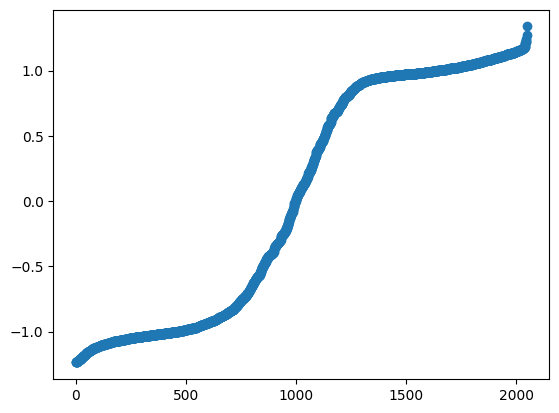

In [18]:
plt.scatter(np.arange(len(r[0])), r[0])

<Axes: ylabel='Density'>

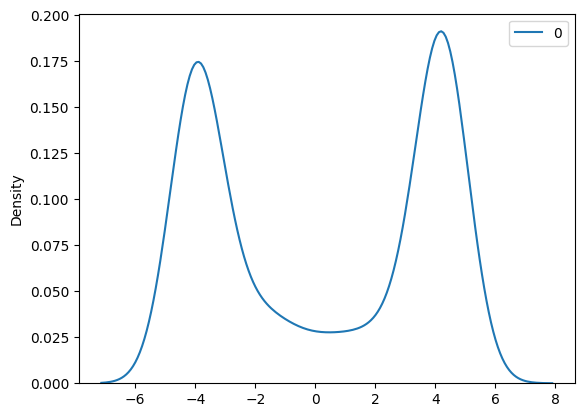

In [19]:
sns.kdeplot(res[0,...])

In [70]:
source_repeat = jnp.ones((1,)) * -0.5
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

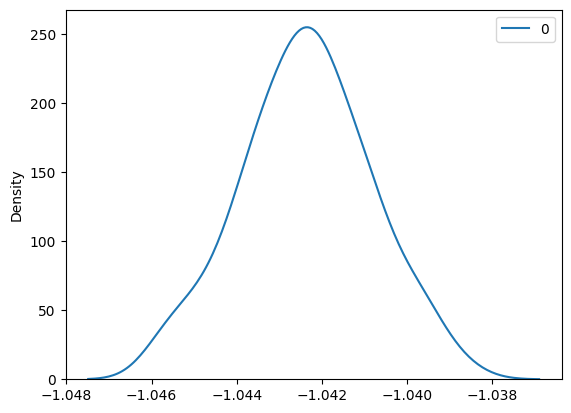

In [71]:
sns.kdeplot(res_const[0,...])

In [202]:
from functools import partial

ts = np.linspace(0,1,300)
saveat=diffrax.SaveAt(ts=ts)

res, sol = otfm.transport(source, seed=0, diffeqsolve_kwargs={"saveat": saveat})

In [203]:
inds = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(sol.ys)), (30,))
tracks = sol.ys[:,inds,0]

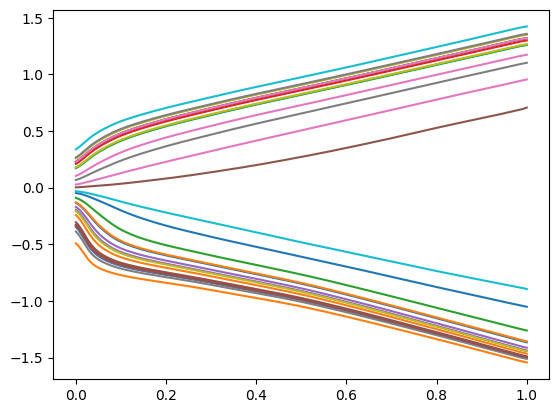

In [204]:
plt.plot(ts, tracks)
plt.show()

In [137]:
t_vec = ts[1:] - ts[:-1]
t_vector = np.tile(t_vec[:, None], (1, tracks.shape[-1]))
y_vector = tracks[1:, ...] - tracks[:-1,...]
t_augmented = np.tile(ts[:, None], (1, tracks.shape[-1]))[:-1, ...]

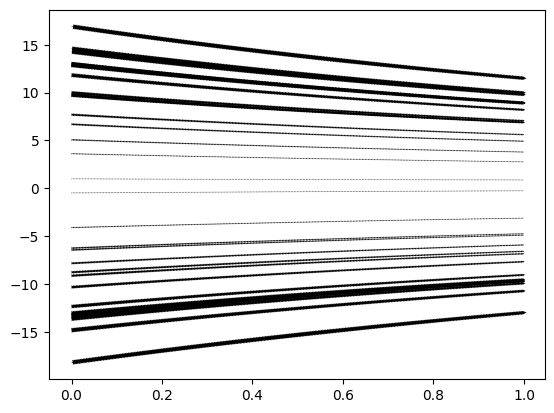

In [138]:
plt.quiver(t_augmented, tracks[:-1], t_vector, y_vector, width=1e-3, headwidth=10, headlength=10, headaxislength=10, angles="xy")

In [139]:
res, sol = otfm.transport(source_repeat, seed=0, diffeqsolve_kwargs={"saveat": saveat})

In [140]:
inds = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(sol.ys)), (30,))
tracks = sol.ys[:,inds,0]

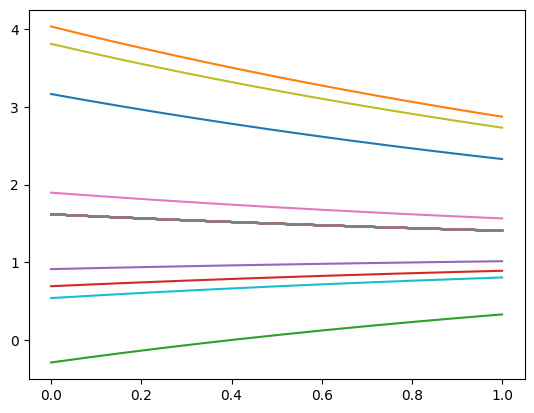

In [141]:
plt.plot(ts, tracks)
plt.show()

In [114]:
tracjs

NameError: name 'tracjs' is not defined

In [328]:
ofm(source, target, 64, 64)

100%|██████████| 1000/1000 [00:05<00:00, 186.10it/s]


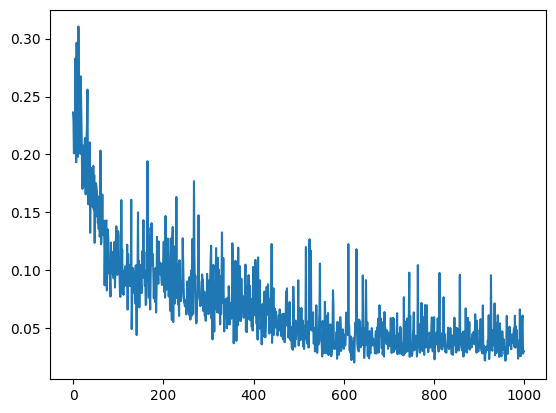

In [329]:
plt.plot(np.arange(len(ofm.metrics["loss"])), ofm.metrics["loss"])

<Axes: ylabel='Density'>

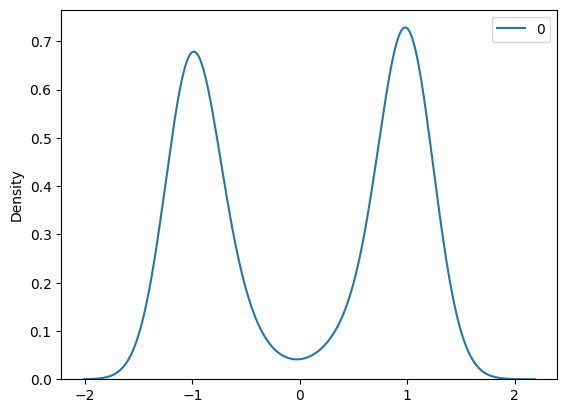

In [330]:
res,_ = ofm.transport(source)
sns.kdeplot(res[0,...])

In [331]:
solution = diffrax.diffeqsolve(
                    diffrax.ODETerm(lambda t,y,args: ofm.state_mlp.apply_fn({"params":ofm.state_mlp.params}, t=t, x=y)),
                    diffrax.Tsit5(),
                    t0=0,
                    t1=1,
                    dt0=None,
                    y0=source, # here we swap source and noise
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    saveat=diffrax.SaveAt(ts=ts),
                    )

In [340]:
inds = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(solution.ys)), (30,))
tracks = solution.ys[:,inds,0]

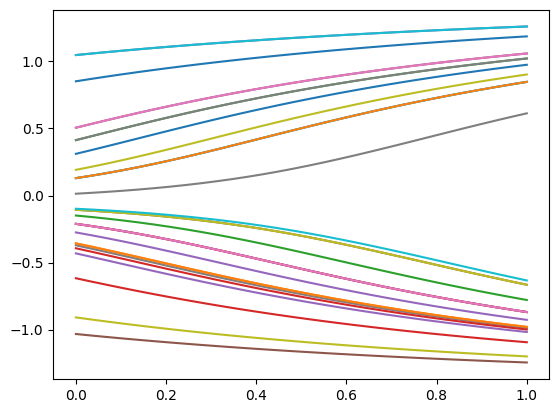

In [341]:
plt.plot(ts, tracks)
plt.show()

In [342]:
t_vec = ts[1:] - ts[:-1]
t_vector = np.tile(t_vec[:, None], (1, tracks.shape[-1]))
y_vector = tracks[1:, ...] - tracks[:-1,...]
t_augmented = np.tile(ts[:, None], (1, tracks.shape[-1]))[:-1, ...]

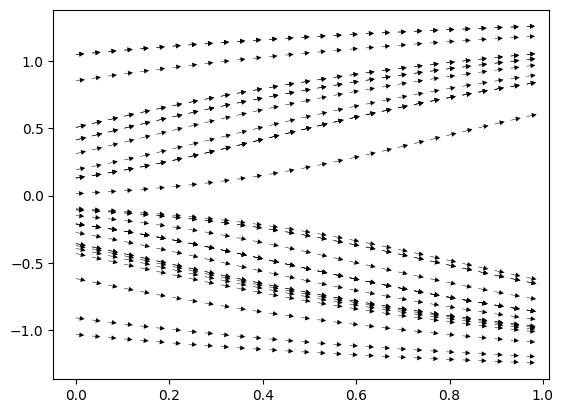

In [343]:
plt.quiver(t_augmented, tracks[:-1], t_vector, y_vector, width=1e-3, headwidth=10, headlength=10, headaxislength=10, angles="xy")

In [75]:
source_repeat = jnp.ones((1,)) * -2
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

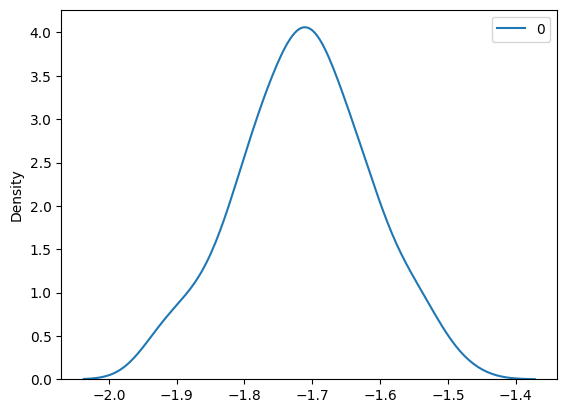

In [76]:
sns.kdeplot(res_const[0,...])

In [36]:
source_repeat = jnp.ones((1,)) * 0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

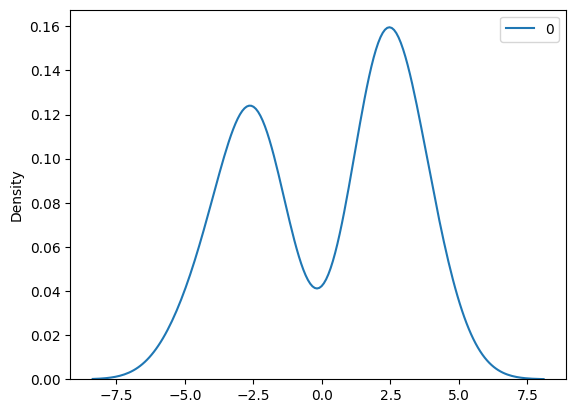

In [37]:
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

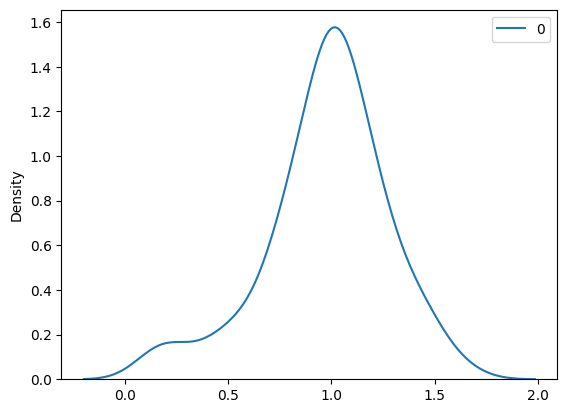

In [40]:
source_repeat = jnp.ones((1,)) * 0.5
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

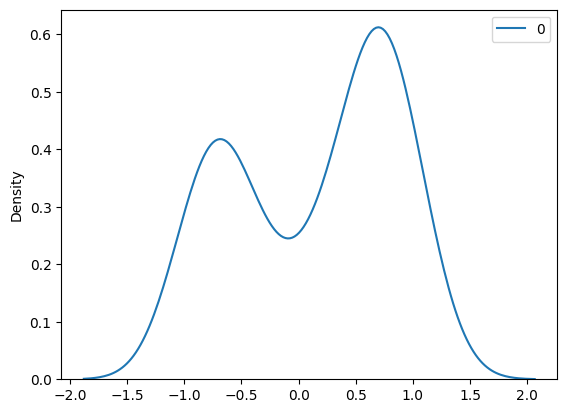

In [41]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])

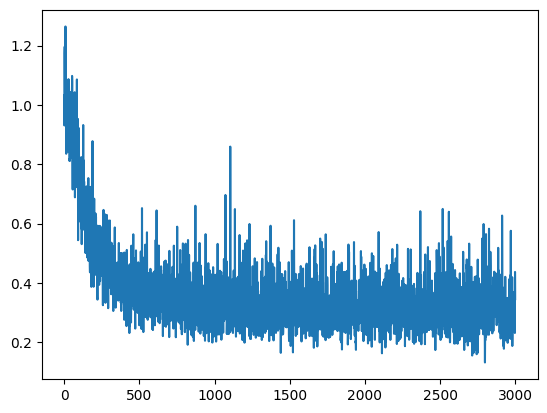

In [40]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])